# Import librairies

In [1]:
from numpy import *
from pylab import *
from itertools import product
import os
import time
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap
from mne import pick_types, find_layout
from mne import *

# Setup Functions

In [2]:
def scipy_ttest_ind(cond1, cond2): #calculates the T-test for the means of TWO INDEPENDENT samples of scores.
    from scipy.stats import ttest_ind
    stat, p_vals = ttest_ind(cond1, cond2, permutations=1000)
    return p_vals, stat

def scipy_ttest_rel(cond1, cond2): #calculates the T-test on TWO RELATED samples of scores
    from scipy.stats import ttest_rel
    stat, p_vals = ttest_rel(cond1, cond2)
    return p_vals, stat

def fdr(test_func):
    def corr_p_vals(cond1, cond2):
        from mne.stats import fdr_correction
        p_vals, stat = test_func(cond1, cond2)
        _, p_vals_corr = fdr_correction(p_vals)
        return p_vals_corr, stat
    return corr_p_vals

def GetStatMask(cond1, cond2, stat_test_func, p_thresh=0.05):
    """Produce sensor-level binary statistical mask"""
    # ----------------------------------------------------------------- #
    p_vals, stat = stat_test_func(cond1, cond2)
    mask = np.array(p_vals <= p_thresh)
    return mask, p_vals, stat

# -- Define function that can read info from both fif and ds files -- #
import contextlib

# -- Works both in python2 and python3 -- #
try:
    from cStringIO import StringIO
except ImportError:
    from io import StringIO
# --------------------------------------- #
    
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = StringIO()
    yield
    sys.stdout = save_stdout

def read_info_custom(fname):
    """Read info from .fif or from .ds"""
    from os.path import splitext
    _,ext = splitext(fname)
    if ext == '.fif':
        from mne.io import read_info
        info = read_info(fname)
    elif ext == '.ds':
        from mne.io import read_raw_ctf
        with nostdout():
            raw = read_raw_ctf(fname)
        info = raw.info
    else:
        raise RuntimeError('Unknown format for {}'.format(fname))
    return info

ch_names_info =['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16',
           'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31',
           'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E41', 'E42', 'E43', 'E44', 'E46',
           'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61',
           'E62', 'E63','E64','E65']

# Mean

In [221]:
path = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/c1_c2_4sec_3_9/new_c1_c2_63_elec/'
savefile = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/c1_c2_4sec_3_9/mean_balanced_c1_c2/'
Cx = 'c2'
subjects = ['S2', 'S3','S4','S5','S6','S8','S10']
temp_con = '_conscious_'
temp_uncon = '_unconscious_'

x_con, x_uncon = [], []
for num, k in enumerate(subjects):
    print('Load '+ k + '(' + str(num) +')')

    # Unconscious :
    uncon = sio.loadmat(path + k + temp_uncon + '4sec_3_9_' + Cx +  '_63.mat') [Cx]
    uncon = np.mean(uncon, axis=1)[...,np.newaxis]
    sio.savemat(savefile+k +'_'+ Cx + '_unconscious_mean.mat',{'uncon': uncon})

    # Conscious :   
    con = sio.loadmat(path + k + temp_con  + '4sec_3_9_' + Cx +  '_63.mat') [Cx]
    
    #con=np.zeros_like(uncon) 
    #if len(con_temp[1]) < len(uncon[1]):
     #   con = con_temp
    #else:
     #   for jj in range(len(con)):
            #con[jj,:] = np.random.choice(con_temp[jj],len(uncon[1]),replace=False)
    con = np.mean(con, axis=1)[...,np.newaxis]
    
    sio.savemat(savefile+k +'_'+ Cx + '_conscious_mean.mat',{'con': con})

    print(con.shape)        
    print(uncon.shape)

    x_con.append(con)
    x_uncon.append(uncon)
       
x_con = np.array(x_con)
x_con = np.squeeze(x_con)

x_uncon = np.array(x_uncon)
x_uncon = np.squeeze(x_uncon)

sio.savemat(savefile+'Sall_' + Cx + '_conscious_mean.mat',{'x_con': x_con})
sio.savemat(savefile+'Sall_' + Cx + '_unconscious_mean.mat',{'x_uncon': x_uncon})

Load S2(0)
(63, 1)
(63, 1)
Load S3(1)
(63, 1)
(63, 1)
Load S4(2)
(63, 1)
(63, 1)
Load S5(3)
(63, 1)
(63, 1)
Load S6(4)
(63, 1)
(63, 1)
Load S8(5)
(63, 1)
(63, 1)
Load S10(6)
(63, 1)
(63, 1)


# Compute Statistics

In [27]:
path = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/c1_c2_2sec_2_7/ROC_LOC/'
savepath = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/c1_c2_2sec_2_7/stats/'
Cx = 'c1'

Data_conscious_stats = sio.loadmat(path + 'Sall_' + Cx + '_con.mat')['Sall_' + Cx + '_con'].T
Data_unconscious_stats = sio.loadmat(path+'Sall_'+ Cx +'_uncon.mat')['Sall_' + Cx + '_uncon'].T
Data_con_uncon = Data_conscious_stats - Data_unconscious_stats

ttest, pvals,_ = stats.permutation_t_test(Data_con_uncon, n_permutations=100, tail=0, n_jobs=1)
print(pvals)
sio.savemat(savepath+'Stats_'+Cx+'_pvals.mat',{'pvals': pvals})
sio.savemat(savepath+'Stats_'+Cx+'_ttest.mat',{'ttest': ttest})

[ 0.06930693  0.07920792  0.02970297  0.02970297  0.04950495  0.02970297
  0.02970297  0.02970297  0.02970297  0.02970297  0.04950495  0.10891089
  0.02970297  0.04950495  0.02970297  0.02970297  0.04950495  0.02970297
  0.04950495  0.04950495  0.06930693  0.06930693  0.06930693  0.06930693
  0.06930693  0.06930693  0.15841584  0.06930693  0.16831683  0.11881188
  0.20792079  0.06930693  0.81188119  1.          0.06930693  0.41584158
  0.06930693  0.41584158  0.06930693  0.20792079  0.11881188  0.16831683
  0.15841584  0.11881188  0.16831683  0.06930693  0.08910891  0.06930693
  0.04950495  0.10891089  0.02970297  0.02970297  0.08910891  0.10891089
  0.06930693  0.06930693  0.02970297  0.20792079  0.06930693  0.06930693
  0.06930693  0.06930693  0.06930693]


# Barplot

<IPython.core.display.Javascript object>


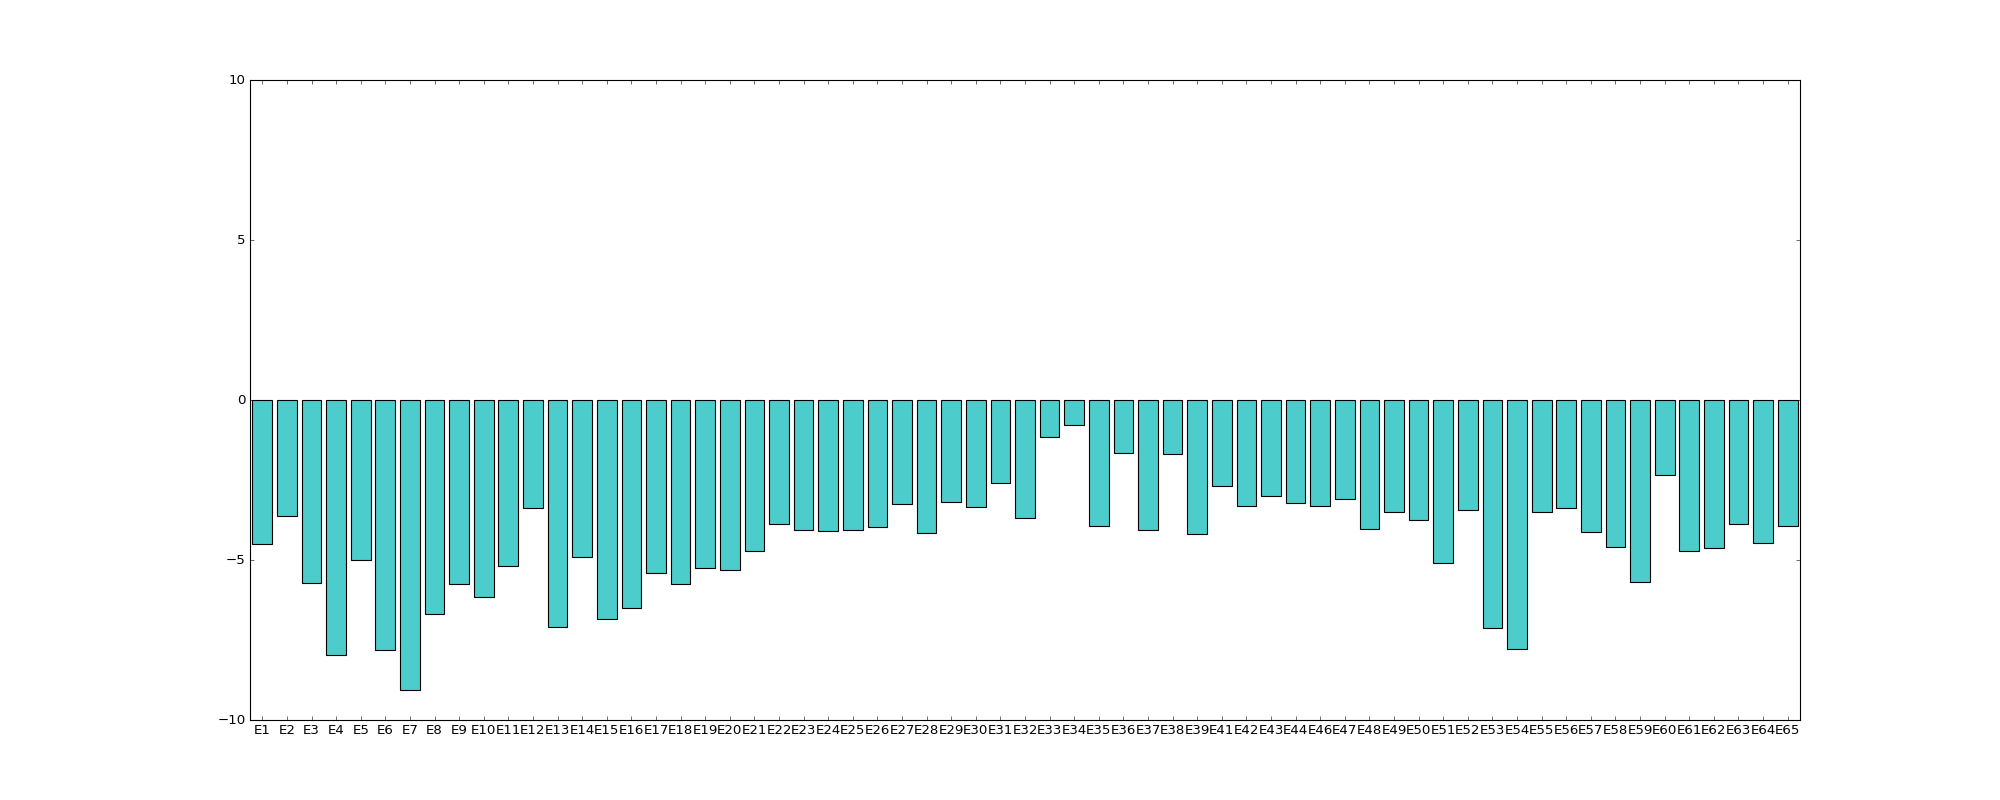

In [28]:
ind = np.arange(0.5,63.5,1)    # the x locations for the groups

fig = plt.figure(figsize = (25,10))
plt.bar(ind,ttest, color=(0.3,0.8,0.8), width=0.8,tick_label = ch_names_info,align='center')
xlim(0,63)
ylim(-10,10)
plt.savefig(savepath + 'ttest_shallow_'+Cx+'_bar.png', dpi = 300)

# Topoplot Statistics

<IPython.core.display.Javascript object>


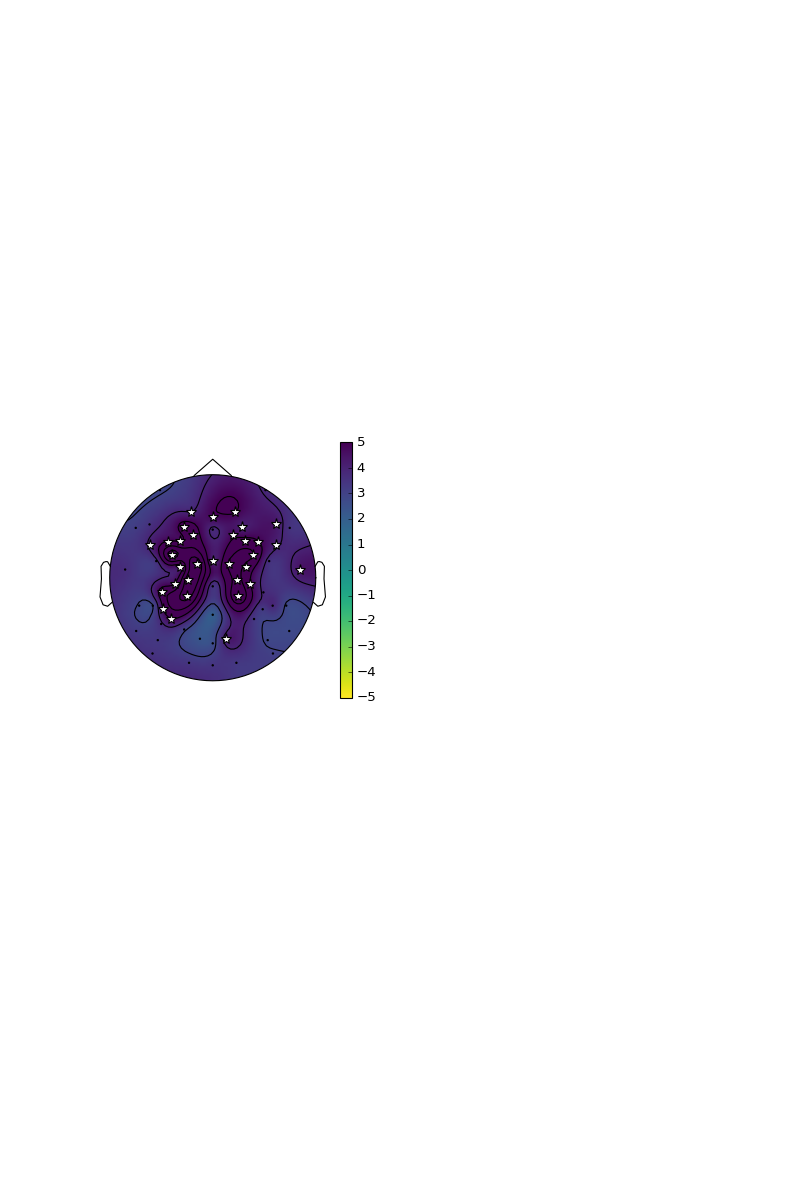

In [24]:
sensors_pos = sio.loadmat('/home/thomasthiery/Dropbox/Rep_MATLAB/electrodes_sevo_new.mat')['electrodes_sevo_new']

path = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/New_PE/stats/'

pval = sio.loadmat(path + 'Stats_'+Cx+'_pvals.mat') [ 'pvals'].T 
pval = np.squeeze(pval)
data = sio.loadmat(path + 'Stats_'+Cx+'_ttest.mat') [ 'ttest'].T 
data = np.squeeze(data)

mask_default = np.full((len(data)), False, dtype=bool)
mask = np.array(mask_default)
mask[pval < 0.05] = True

mask_params = dict(marker='*', markerfacecolor='w', markersize=10) # significant sensors appearence

fig = plt.figure(figsize = (10,15))
plt.subplot(1,2,1)

ax,_ = plot_topomap(data, sensors_pos,
                    cmap='viridis_r', show=False, vmin=-5, vmax=5, mask = mask, mask_params = mask_params)

fig.colorbar(ax, shrink=0.25)
plt.savefig(path + 'ttest_shallow_'+Cx+'_topo.png', dpi = 300)

# Topoplot mean c1 c2

<IPython.core.display.Javascript object>


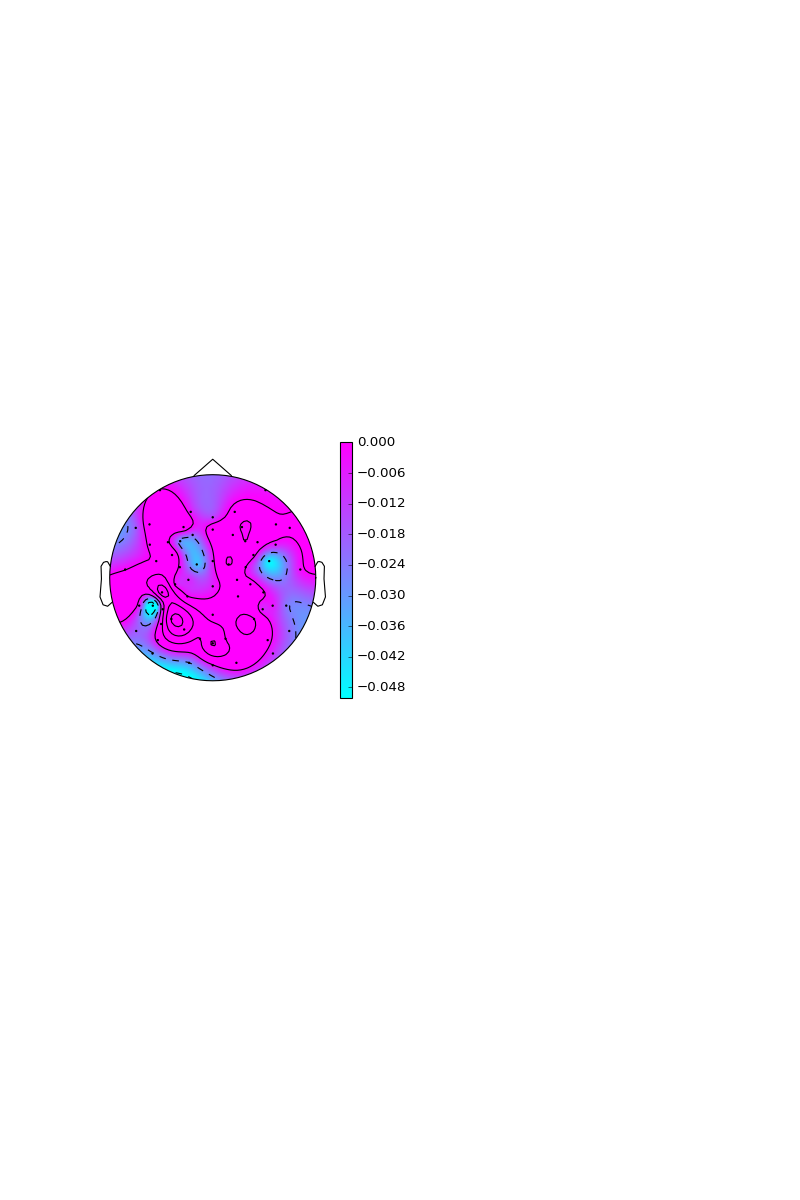

In [208]:
sensors_pos = sio.loadmat('/home/thomasthiery/Dropbox/Rep_MATLAB/electrodes_sevo_new.mat')['electrodes_sevo_new']
mask_default = np.full((len(data)), False, dtype=bool)
mask = np.array(mask_default)

filepath = '/home/thomasthiery/Dropbox/Rep_MATLAB/Analysis_sevo_2_7_new/c1_c2_4sec_3_9/mean_balanced_c1_c2/'
data_mean = sio.loadmat(filepath + 'Sall_c2_conscious_mean') ['x_con'].T
data_mean = np.mean(data_mean, axis=1)

data_mean = np.squeeze(data_mean)

fig = plt.figure(figsize = (10,15))
plt.subplot(1,2,1)
ax,_ = plot_topomap(data_mean, sensors_pos,
                    cmap='cool', show=False, mask = mask, mask_params = mask_params,vmin=-0.05, vmax=0)

fig.colorbar(ax, shrink=0.25)
plt.savefig(filepath + 'Sall_c2_conscious_mean.png', dpi = 300)